In [51]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans #import k-means clustering
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, pdist


In [162]:
def elbow_scores(data, max_num, min_num=1):
    avgs = pd.DataFrame(columns=['cluster_num', 'score'])

    for n in range(min_num,max_num+1):
        km_elbow = KMeans(n_clusters=n).fit(data) 
        centroids = [km_elbow.cluster_centers_]
        Dists_k = [cdist(data, cent, 'euclidean') for cent in centroids]

        dist = [np.min(D,axis=1) for D in Dists_k]
        avg = [sum(d)/data.shape[0] for d in dist]
        avgs = avgs.append({'cluster_num': n, 'score': avg[0]}, ignore_index=True)
    #return avgs

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title("Elbow Scores", fontsize=18)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Avg Within SS")
    ax.plot(avgs.cluster_num, avgs.score,'r-')

def get_kmeans_labels(data, num_clusters):
    km = KMeans(n_clusters=num_clusters) 
    results=km.fit(data) 
    return results.labels_

In [21]:
# data paths
data_path = "./data"
Yelp_BK_path = data_path +  "/Yelp/BK/"
Yelp_MN_path = data_path + "/Yelp/MN/"
path_census_tracts = './data/ACS/CensusTracts'

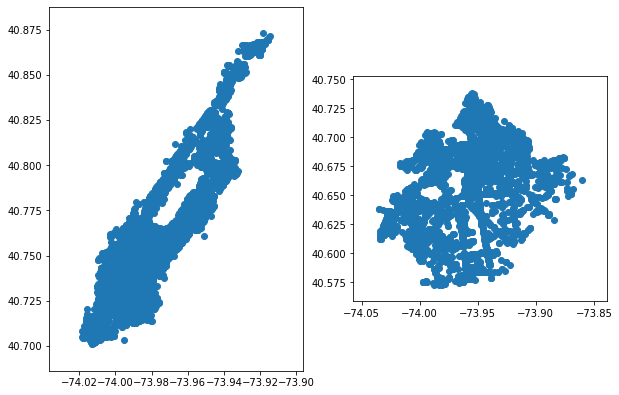

In [172]:
# Reading in Yelp shapefiles 
MN_Yelp = gpd.read_file(Yelp_MN_path + "MN_Yelp_CensusTract_NTA.shp")
BK_Yelp = gpd.read_file(Yelp_BK_path + "BK_Yelp_CensusTract_NTA.shp")

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
MN_Yelp.plot(ax=axes[0])
BK_Yelp.plot(ax=axes[1])

In [176]:
def massage_data(data):
    data = data.sort_values(by=['price'])
    data['price_cluster'] = pd.factorize(data['price'])[0]+1
    data = data[data['price_cluster'] !=5] ##filters out MISSING prices 
    data['NTACode_fact'] = pd.factorize(data['NTACode'])[0]+1
    return data

MN_Yelp = massage_data(MN_Yelp)
BK_Yelp = massage_data(BK_Yelp)

# print(MN_Yelp.head())

In [184]:
print(BK_Yelp.columns)
columns = ['latitude', 'longitude','review_cou','rating', 'price_cluster']

BK_Yelp_sub = BK_Yelp[columns]
BK_Yelp_sub

Index(['id', 'alias', 'name', 'is_closed', 'review_cou', 'rating', 'price',
       'categories', 'latitude', 'longitude', 'address', 'city', 'zipcode',
       'state', 'country', 'index_righ', 'NTACode', 'NTAName', 'Households',
       '0-25k', '25k-50k', '50k-75k', '75k-100k', '100k-125k', '125k-150k',
       '> 150k', 'MeanLifeEx', 'geometry', 'price_cluster', 'NTACode_fact',
       'cluster'],
      dtype='object')


,latitude,longitude,review_cou,rating,price_cluster
2903,40.628952,-74.012235,11,4.5,1
1727,40.679230,-73.995380,2,4.5,1
2162,40.661181,-73.997004,11,4.0,1
3965,40.668086,-73.906622,6,3.0,1
1742,40.678898,-74.010712,13,3.5,1
...,...,...,...,...,...
1723,40.679977,-73.997215,29,3.0,4
992,40.712260,-73.966410,96,4.5,4
4299,40.605003,-73.980843,8,2.5,4
4456,40.591507,-73.960846,33,4.0,4


In [185]:
BK_Yelp_sub['review_cou']=(BK_Yelp_sub['review_cou']-BK_Yelp_sub['review_cou'].mean())/BK_Yelp_sub['review_cou'].std()


C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


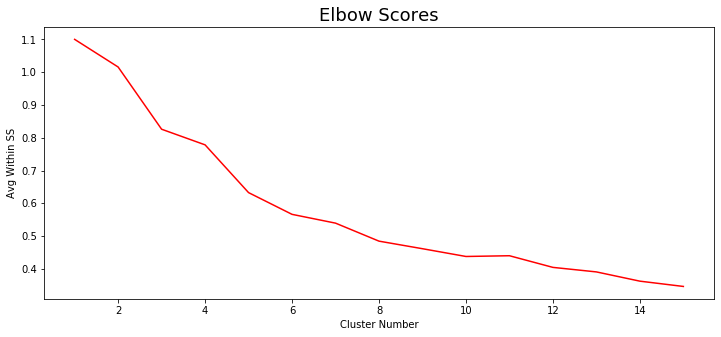

In [186]:
elbow_scores(BK_Yelp_sub, 15)

In [187]:
labels = get_kmeans_labels(BK_Yelp_sub, 8)
BK_Yelp['cluster'] = labels
BK_Yelp.head()

,id,alias,name,is_closed,review_cou,rating,price,categories,latitude,longitude,...,50k-75k,75k-100k,100k-125k,125k-150k,> 150k,MeanLifeEx,geometry,price_cluster,NTACode_fact,cluster
2903,tp0rIpu4IWnatFZHycozCg,great-wall-chinese-take-out-restaurant-brooklyn,Great Wall Chinese Take-Out Restaurant,0,11,4.5,$,chinese|seafood,40.628952,-74.012235,...,0.178804,0.099932,0.091440,0.053125,0.127038,82.482353,POINT (-74.012235 40.62895200000001),1,1,5
1727,GE7mEVa1wm6BTLMe-blu7w,smith-street-deli-and-grocery-brooklyn,Smith Street Deli & Grocery,0,2,4.5,$,delis|grocery|organic_stores,40.679230,-73.995380,...,0.103363,0.086384,0.079438,0.064884,0.361852,80.354545,POINT (-73.99538000000003 40.67923),1,2,5
2162,eGL5fu_rXW22n0TqnfjDWQ,castillo-de-jagua-brooklyn-2,Castillo de Jagua,0,11,4.0,$,latin,40.661181,-73.997004,...,0.163639,0.109852,0.086526,0.035258,0.096120,80.692857,POINT (-73.99700370000002 40.6611815),1,3,5
3965,svNleiTRS0Pinpa5u393Eg,number-one-great-wall-brooklyn,Number One Great Wall,0,6,3.0,$,chinese,40.668086,-73.906622,...,0.113989,0.052220,0.030978,0.014441,0.016584,74.926667,POINT (-73.9066217 40.6680863),1,4,1
1742,0odtQty6tMRPQ7UrNysUxw,wen-gee-house-new-york,Wen Gee House,0,13,3.5,$,chinese,40.678898,-74.010712,...,0.103363,0.086384,0.079438,0.064884,0.361852,80.354545,POINT (-74.010712 40.678898),1,2,1


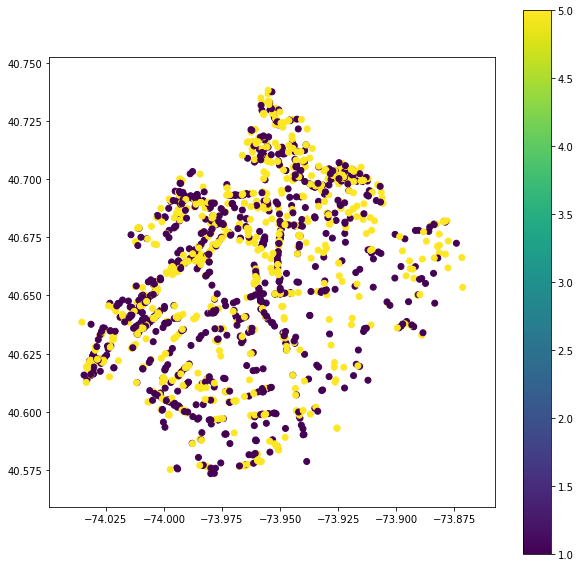

In [193]:
f, ax = plt.subplots(figsize=(10, 10))
BK_Yelp[BK_Yelp['cluster'].isin([1,5])].plot(ax=ax, column='cluster', legend=True)

In [189]:
BK_Yelp[['cluster','review_cou','rating','price_cluster']].groupby(['cluster']).agg(['count','mean','sum'])

review_cou                      rating                    \
             count         mean     sum  count      mean     sum   
cluster                                                            
0              894   110.215884   98533    894  4.206935  3761.0   
1              821    49.969549   41025    821  3.292326  2703.0   
2              420   456.490476  191726    420  3.854762  1619.0   
3                7  3667.714286   25674      7  3.857143    27.0   
4              837    96.175627   80499    837  3.206691  2684.0   
5              738    60.883469   44932    738  4.224932  3118.0   
6              482    26.205394   12631    482  2.017635   972.5   
7               45  1301.044444   58547     45  3.911111   176.0   

        price_cluster                  
                count      mean   sum  
cluster                                
0                 894  2.089485  1868  
1                 821  1.000000   821  
2                 420  1.988095   835  
3                   7  2.142857    15  
4                 837  2.088411  1748  
5                 738  1.000000   738  
6                 482  1.114108   537  
7                  45  2.111111    95

In [101]:
BK_Yelp[BK_Yelp['cluster'] == 1]

,id,alias,name,is_closed,review_cou,rating,price,categories,latitude,longitude,...,0-25k,25k-50k,50k-75k,75k-100k,100k-125k,125k-150k,> 150k,MeanLifeEx,geometry,cluster
6,a6SzfZ2F-uELmymusQVMBg,karczma-brooklyn,Karczma,0,549,4.5,$$,polish,40.729977,-73.955128,...,0.200210,0.136843,0.151883,0.135980,0.105529,0.086914,0.182642,80.163636,POINT (-73.955128 40.72997700000001),1
10,z5EpI39omxW6aK_X2uHi8A,lobster-joint-brooklyn,Lobster Joint,0,646,4.0,$$,seafood,40.735400,-73.955280,...,0.200210,0.136843,0.151883,0.135980,0.105529,0.086914,0.182642,80.163636,POINT (-73.95528 40.7354),1
28,pGr5QuQU7Ur5GHLvXbT8bw,paulie-gees-brooklyn,Paulie Gee's,0,1205,4.5,$$,pizza|vegan|italian,40.729546,-73.958568,...,0.200210,0.136843,0.151883,0.135980,0.105529,0.086914,0.182642,80.163636,POINT (-73.958568 40.729546),1
40,1Q3oaJahyGRogDWgpo7PIw,five-leaves-brooklyn-2,Five Leaves,0,1581,4.0,$$,newamerican|coffee|bars,40.723718,-73.951599,...,0.200210,0.136843,0.151883,0.135980,0.105529,0.086914,0.182642,80.163636,POINT (-73.95159864 40.72371831),1
95,3DNtS1_3gobrYQBAwDx4DA,calexico-greenpoint-brooklyn-2,Calexico - Greenpoint,0,692,3.5,$$,mexican|salad,40.724160,-73.951320,...,0.200210,0.136843,0.151883,0.135980,0.105529,0.086914,0.182642,80.163636,POINT (-73.95132 40.72416),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,tC4D1a5CR69VyK5VrHimQw,suede-east-flatbush,Suede,0,1122,3.5,$$,caribbean,40.644550,-73.923420,...,0.288361,0.237502,0.173422,0.118124,0.068471,0.048253,0.065866,78.488235,POINT (-73.92341999999999 40.64455),1
4778,_WWJcqUTGFCCVp0cymu0wQ,footprints-cafe-brooklyn,Footprints Cafe,0,775,3.0,$$,caribbean|desserts|vegetarian,40.644610,-73.921190,...,0.288361,0.237502,0.173422,0.118124,0.068471,0.048253,0.065866,78.488235,POINT (-73.92119 40.64461),1
4926,DVSm03qNU7zE1mv1QSKnsA,mangoseed-restaurant-brooklyn-2,MangoSeed Restaurant,0,790,4.0,$$,caribbean|breakfast_brunch|cocktailbars,40.654149,-73.959371,...,0.274366,0.247121,0.171182,0.116731,0.064386,0.044329,0.081885,80.105882,POINT (-73.95937085 40.65414923),1
4964,D1jp3pfGvyYyaXBN8iJRBg,the-farm-on-adderley-brooklyn,The Farm On Adderley,0,1157,4.0,$$,newamerican|breakfast_brunch|cocktailbars,40.639650,-73.967540,...,0.254438,0.227006,0.191633,0.119745,0.074639,0.039136,0.093403,80.307692,POINT (-73.96754 40.63965),1


C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


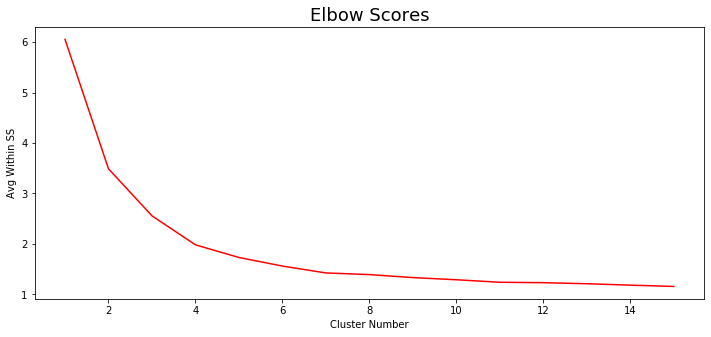

In [158]:
columns = ['latitude', 'longitude','review_cou','rating', 'price_cluster','NTACode_fact']
MN_Yelp_sub = MN_Yelp[columns]

# MN_Yelp_sub['review_cou'].div(MN_Yelp_sub['review_cou'].sum(axis=1), axis=0).dropna()

MN_Yelp_sub['review_cou']=(MN_Yelp_sub['review_cou']-MN_Yelp_sub['review_cou'].mean())/MN_Yelp_sub['review_cou'].std()

elbow_scores(MN_Yelp_sub, 15)

In [159]:
labels = get_kmeans_labels(MN_Yelp_sub, 4)
MN_Yelp['cluster'] = labels
MN_Yelp.head()

,id,alias,name,is_closed,review_cou,rating,price,categories,latitude,longitude,...,50-75k,75-100k,100-125k,125-150k,> 150k,MeanLifeEx,geometry,price_cluster,NTACode_fact,cluster
4689,hGbfDMM2POAevBXe-H3qgg,chipotle-mexican-grill-new-york-60,Chipotle Mexican Grill,0,126,3.5,$,"mexican,hotdogs",40.742059,-74.001218,...,0.10,0.08,0.09,0.07,0.39,81.627273,POINT (-74.00121808999999 40.74205884),1,1,3
1963,gF4WOspnk9KkUWKDi0uS9g,chipotle-mexican-grill-new-york-66,Chipotle Mexican Grill,0,72,2.0,$,"mexican,hotdogs",40.786105,-73.977628,...,0.11,0.09,0.09,0.06,0.37,84.056250,POINT (-73.977628 40.786105),1,2,3
1964,aPtFBavkEgpwqFfEwvK4FQ,parliament-coffee-new-york,Parliament Coffee,0,16,3.0,$,"coffee,bakeries,breakfast_brunch",40.779300,-73.974380,...,0.11,0.09,0.09,0.06,0.37,84.056250,POINT (-73.97438000000001 40.7793),1,2,3
1966,XispD33dyhesBXhDLXktVQ,parisian-deli-manhattan,Parisian Deli,0,18,3.0,$,delis,40.785210,-73.972880,...,0.11,0.09,0.09,0.06,0.37,84.056250,POINT (-73.97288 40.78521),1,2,3
7836,w0pDi_iMZd5MqYQ7t5q1dQ,christophers-golden-woks-new-york,Christopher's Golden Woks,0,53,3.5,$,chinese,40.732840,-74.008360,...,0.10,0.09,0.08,0.07,0.44,84.766667,POINT (-74.00836 40.73284),1,3,3


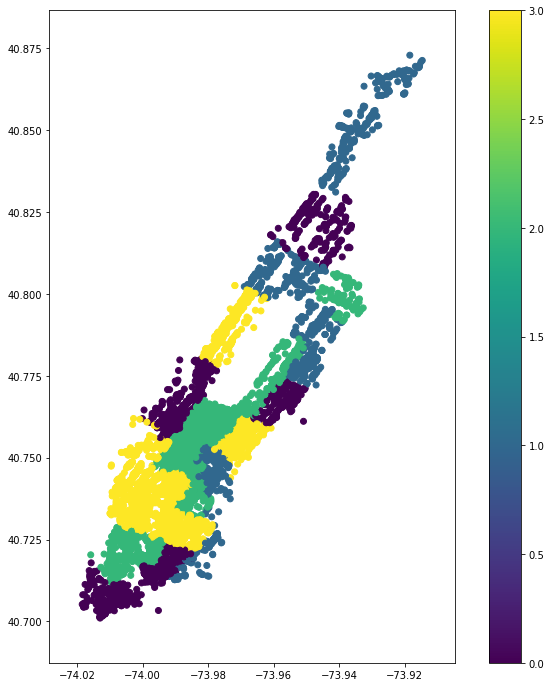

In [160]:
f, ax = plt.subplots(1, figsize=(12, 12))
MN_Yelp.plot(ax=ax, column='cluster', legend=True)

In [161]:
MN_Yelp[['cluster','review_cou','rating','price_cluster']].groupby(['cluster']).agg(['count','mean','sum'])

review_cou                     rating                   price_cluster  \
             count        mean     sum  count      mean     sum         count   
cluster                                                                         
0             1793  262.992750  471546   1793  3.569716  6400.5          1793   
1             1202  177.552413  213418   1202  3.482945  4186.5          1202   
2             2294  279.507847  641191   2294  3.498256  8025.0          2294   
3             2389  339.089577  810085   2389  3.626622  8664.0          2389   

                         
             mean   sum  
cluster                  
0        1.747909  3134  
1        1.658902  1994  
2        1.893200  4343  
3        1.914609  4574

In [156]:
MN_Yelp[MN_Yelp['cluster'].isin([3,7])].columns

Index(['id', 'alias', 'name', 'is_closed', 'review_cou', 'rating', 'price',
       'categories', 'latitude', 'longitude', 'address', 'city', 'zipcode',
       'state', 'country', 'index_righ', 'NTACode', 'NTAName', '0-25k',
       '25-50k', '50-75k', '75-100k', '100-125k', '125-150k', '> 150k',
       'MeanLifeEx', 'geometry', 'price_cluster', 'cluster'],
      dtype='object')